In [24]:
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
import torch
import os
os.environ['TORCH_HOME'] = '.'

model_zoe_n = torch.hub.load(repo_or_dir = ".", model = "ZoeD_N", source="local", pretrained=True)

img_size [384, 512]
Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


In [25]:
yolo= torch.hub.load(
        repo_or_dir = 'yolov5',
        model = 'custom', 
        path='TC3_WR.pt', 
        source='local')

YOLOv5 🚀 2022-8-10 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
Model summary: 212 layers, 20873139 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [26]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
zoe = model_zoe_n.to(DEVICE)

In [27]:
import requests
import json
import numpy as np
import base64,cv2
from PIL import Image, ImageOps
# Define gradient colors
red = (255, 0, 0)
green = (0, 255, 0)
yellow = (255, 255, 0)
# Define color map
color_map = {
    'truck': (0, 0, 255),  # Red
    'safety': (0, 255, 0),  # Green
    'illegal': (255, 0, 0),  # Blue
    'cone': (255, 255, 0),  # Blue
}

In [45]:
file = 'Demo/10.png'

img_pil = Image.open(file).convert("RGB")  # load

In [46]:
yolo.to("cuda")

outputs = yolo(img_pil).pandas().xyxy[0]
outputs

,xmin,ymin,xmax,ymax,confidence,class,name
0,1315.012085,546.006714,1589.228394,826.432739,0.969521,3,truck
1,542.631592,515.421692,815.402100,830.402893,0.958424,3,truck
2,708.564331,742.530579,810.876221,922.693359,0.943370,1,illegal
3,374.284241,689.834351,415.290253,806.551392,0.918148,1,illegal
4,757.954834,745.238525,786.997009,767.119446,0.911153,0,safety


In [47]:
outputs = outputs[outputs['confidence']>0.5]

In [48]:
depth_numpy = zoe.infer_pil(img_pil)  # as numpy

# Convert the depth values to integer values between 0 and 255
depth_int = (255 * (depth_numpy - depth_numpy.min()) / (depth_numpy.max() - depth_numpy.min())).astype(np.uint8)

# Convert the NumPy array to a PIL image
depth_pil = Image.fromarray(depth_int)

In [49]:
results = {}
# 對於YOLOv5模型預測的每一個物體，都進行深度估算
for i, co in outputs.iterrows():
    y1 = int(co['ymin'])
    y2 = int(co['ymax'])
    x1 = int(co['xmin'])
    x2 = int(co['xmax'])
    deep = int(np.median(depth_int[y1:y2, x1:x2]))
    results[str(i)] = {c: str(co[c]) for c in co.index}
    results[str(i)]['deep'] = str(deep)
    results[str(i)]['area'] = (x2 - x1) * (y2 - y1)


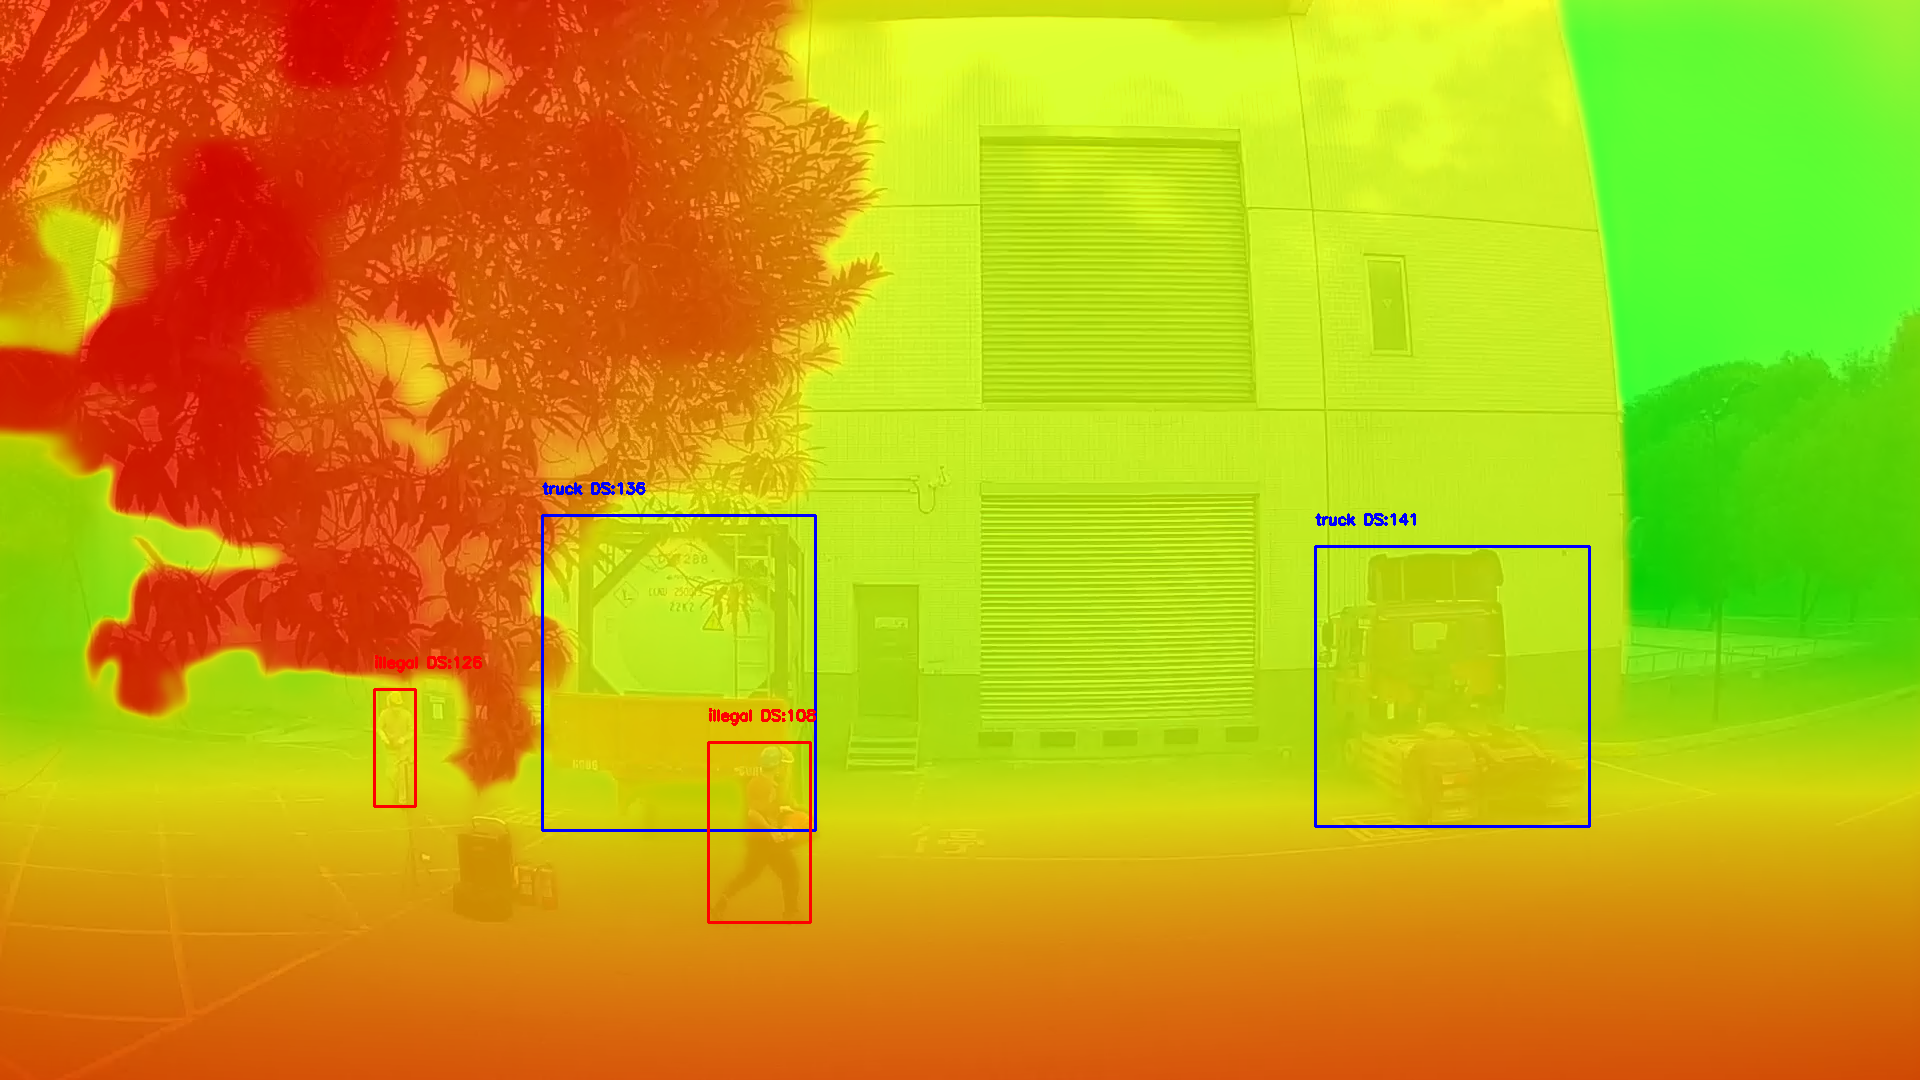

In [50]:
# Apply color map using gradient
depth_col = ImageOps.colorize(depth_pil, red, green, yellow)
result_img = Image.blend(depth_col, img_pil, alpha = 0.2)

img_arr = np.array(result_img)
# Loop over the dictionary and draw rectangles
for key in results:
    x1 = int(float(results[key]['xmin']))
    y1 = int(float(results[key]['ymin']))
    x2 = int(float(results[key]['xmax']))
    y2 = int(float(results[key]['ymax']))
    area = results[key]['area']
    if area > 1200 :
        deep = int(np.median(depth_int[y1:y2, x1:x2]))
        name = results[key]['name']
        color = color_map.get(name, (255, 255, 255))  # Get color from color map, default to white
        thickness = 2  # Set thickness of rectangle to 2 pixels
        cv2.rectangle(img_arr, (x1, y1), (x2, y2), color, thickness)
        font = cv2.FONT_HERSHEY_SIMPLEX  # Define font type
        (text_width, text_height), _ = cv2.getTextSize(name, font, 1, 2)  # Get text size
        text_x = x1  # Set x position of text to be the same as x1 of rectangle
        text_y = y1 - text_height  # Set y position of text to be above rectangle
        cv2.putText(img_arr, f'{name} DS:{deep}', (text_x, text_y), font, 0.5, color, 2)  # Draw text

Image.fromarray(img_arr)